# Assignment 6: Neural Networks and VAEs


STATS305C, Stanford University, Spring 2022


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slinderman/stats305c/blob/master/assignments/hw6/hw6.ipynb)


---

**Name:** 

**Collaborators:** 

---



In this homework assignment, we will explore automatic differentiation, neural networks, and amortized variational inference. 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Bernoulli, Uniform
from torch.distributions.kl import kl_divergence
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import numpy as np
import math
from tqdm.notebook import tqdm

torch.manual_seed(305)

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")

## Problem 1: Optimizing a Quadratic Objective via Gradient Descent

We'll start off by optimizing a simple objective using gradient descent. We will compute the required gradients using PyTorch's automatic differentation capabilities.

Consider the function $f: \mathbb{R}^D \to \mathbb{R}$ given by:
$$ f(\mathbf{x}) = \mathbf{x}^\top \mathbf{A} \mathbf{x} $$
where $\mathbf{A} \in \mathbb{R}^{D \times D}$ is a fixed positive definite matrix. It is obvious that a global minimizer of $f$ is $\mathbf{x}^* = 0$. We will try to recover this known global minimizer using gradient descent. We note that although the objective is seemingly simple, a stochastic version of this objective has been used as a model for neural network loss surfaces (e.g. see [this paper](https://arxiv.org/abs/1803.02021)).

We will simplify the objective further by assuming that $\mathbf{A}$ is diagonal, so $\mathbf{A} = \text{diag}(\mathbf{a})$ for some $\mathbf{a} \in \mathbb{R}_{++}^D$.

### Problem 1a: Gradient Descent with a well-conditioned Objective

Recall the gradient descent update rule for a fixed step size $\alpha$ is:
$$\mathbf{x}^{(k + 1)} \gets \mathbf{x}^{(k)} - \alpha \nabla f(\mathbf{x}^{(k)})$$

Using PyTorch's automatic differentiation system, complete the function below implementing an optimization loop to minimize the objective.

In [ ]:
from tqdm import trange

def f(x, a):
    """ Evaluates the objective.

    Args:
        x: (D,) tensor 
        a: (D,) tensor of positive values
    Returns:
        value: (,) tensor
    """
    return (a * x**2).sum()

def run_optimization(x, a, optimizer, num_iters):
    """ Runs an optimization algorithm on the objective for num_iters.

    Args:
        x: Starting position for optimization. nn.Parameter of shape (D,)
        a: parameter defining curvature of objective. tensor of shape (D,)
        optimizer: a torch.optim Optimizer
        num_iters: number of iterations to run optimization for

    Returns:
        xs: value of x at each iteration. tensor of shape (num_iters + 1, D)
        losses: value of objective at each iterate. tensor of shape (num_iters + 1,)
    """
    losses = []
    # we have to make a copy of the data so that elements of list do not 
    # reference same location in memory
    xs = [x.data.clone()]

    for it in trange(num_iters):

        ###
        # YOUR CODE HERE
        # 1. zero out the gradient
        # 2. compute the loss
        # 3. compute the gradient of the loss
        # 4. take one optimizer step (this will update x in place)
        ...
        # clean out gradients
        optimizer.zero_grad()
        # compute loss
        loss = f(x, a)
        # backward pass
        loss.backward()
        # update 
        optimizer.step()

        # with torch.no_grad():
        losses.append(loss)
        xs.append(x.data.clone())


    # Return the stacked losses and xs
    losses = torch.tensor(losses)
    xs = torch.vstack(xs)
    return xs, losses

We will now run gradient descent on the objective in $D = 2$ dimensions, with $\mathbf{a} = (0.2, 0.2)$. We will use 50 iterations with a learning rate of $\alpha = 0.8$, starting from $\mathbf{x}_0 = (10, 10)$. 

Note that we initialize `x` using `nn.Parameter`, which tells PyTorch we need to compute gradients with respect to `x`. Note that PyTorch's optimizers expect an iterable of `Parameters` to be passed as the first argument, so you must pass in `[x]` rather than `x` itself.

In [ ]:
D = 2
x = nn.Parameter(10 * torch.ones(D))
a = 0.2 * torch.ones(D)

### 
# YOUR CODE HERE
optimizer = torch.optim.SGD([x], lr=8e-1)
xs, losses = run_optimization(x, a, optimizer, num_iters=50)
##

100%|██████████| 50/50 [00:00<00:00, 312.17it/s]


Let's plot the loss curve. As you can see, the objective approaches the optimal value of zero quite quickly.

Text(0, 0.5, 'Objective Value')

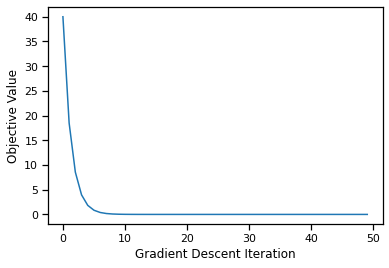

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Gradient Descent Iteration")
plt.ylabel("Objective Value")

Next, let's visualize the trajectory of the gradient descent iterates $\mathbf{x}^{(k)}$.

In [ ]:
def visualize_gradient_descent(xs, a, width=12, grid_size=200):
    """ Visualizes gradient descent when iterates are two-dimensional."""
    
    def batch_f(X):
        """
        Args: 
            X: (N, D) tensor
        """
        return (X**2 * a).sum(dim=1)

    grid_size = 200
    x1s = np.linspace(-width, width, grid_size)
    x2s = np.linspace(-width, width, grid_size)
    X1, X2 = np.meshgrid(x1s, x2s)
    points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
    points = torch.tensor(points, dtype=torch.float)

    Z = batch_f(points).reshape(grid_size, grid_size)

    fig = plt.figure(figsize = (10,7))
    contours = plt.contour(X1, X2, Z, 20)

    plt.plot(xs[:,0], xs[:,1])
    plt.plot(xs[:,0], xs[:,1], '*', label = "Cost function")

    plt.xlabel('$x_1$', fontsize=15)
    plt.ylabel('$x_2$', fontsize=15)
    plt.show()

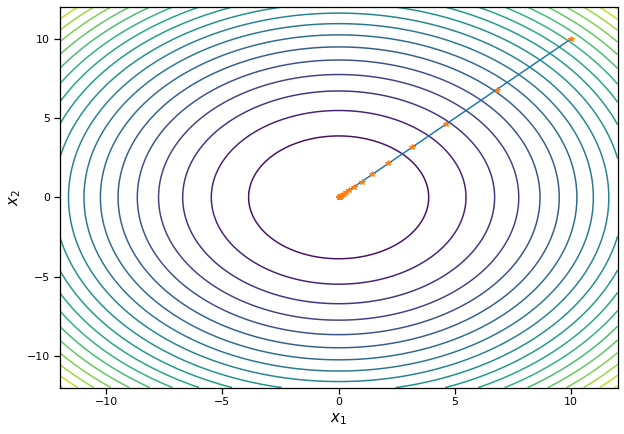

In [ ]:
visualize_gradient_descent(xs, a)

### Problem 1b: Gradient Descent with a Ill-Conditioned Objective

Next, let's see how gradient descent performs on an ill-conditioned objective, where the amount of curvature in each direction varies. For our objective, we can control the amount of curvature using $\mathbf{a}$. Repeat part (a), this time using $\mathbf{a} = (0.05, 1.2)$ while holding all other hyperparameters constant.

In [ ]:
x = nn.Parameter(10 * torch.ones(D))
a = torch.tensor([0.05, 1.2])

###
# YOUR CODE HERE
optimizer = torch.optim.SGD([x], lr=8e-1)
xs, losses = run_optimization(x, a, optimizer, num_iters=50)
##

100%|██████████| 50/50 [00:00<00:00, 3593.29it/s]


Text(0, 0.5, 'Objective Value')

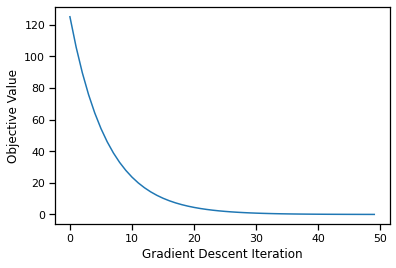

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Gradient Descent Iteration")
plt.ylabel("Objective Value")

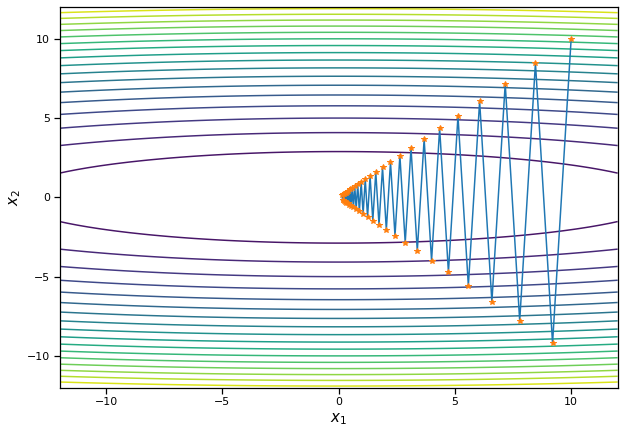

In [ ]:
visualize_gradient_descent(xs, a)

Explain why the gradient descent iterates oscillate around the line $\mathbf{x}_2 = 0$ and suggest one change that could be made to eliminate this behavior, without changing the objective itself.

---

Here, the objective is ill-conditioned (varying curvature/slopes in different) directions, which creates the following problem: we need to take big steps in one direction and small steps in the other. However, vanilla SGD does not do this; it takes a big step in the "small direction" (in order to account for the necessary step in the "big direction"). To rectify this behavior, we might want to pursue an optimizer that scales the directional step sizes with the magnitude of the gradient/curvature. [AdaGrad](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf) is one such algorithm that achieves this; it may be preferable here.

---

### Problem 1c: Optimizing a High-Dimensional Objective

Now let's tackle a more challenging, higher-dimensional problem. We'll use the same objective, but this time use $\mathbf{a} \in \mathbb{R}^{10}$ where:
$$a_i = 10^{-2 + \frac{4(i - 1)}{9}}$$
for $i \in \{1, \dots, 10\}$. This means the curvature of the dimensions ranges from $0.01$ to $100$.

Experiment with different optimizers and hyperparameter settings on this problem, starting from the initial point $x^{(0)} = (10, \dots, 10)$ and run your chosen optimizer for $1000$ iterations. You can see a complete list of optimizers PyTorch has implemented [here](https://pytorch.org/docs/stable/optim.html#algorithms). Find an optimizer/hyperparameter regime that achieves a final loss of less than $0.01$.

In [ ]:
x = nn.Parameter(10 * torch.ones(10))
a = torch.tensor([10**i for i in np.linspace(-2, 2, num=10)])

### 
# YOUR CODE HERE
optimizer = torch.optim.Adam([x], lr=1e-1)
xs, losses = run_optimization(x, a, optimizer, num_iters=1000)
##

100%|██████████| 1000/1000 [00:00<00:00, 4037.45it/s]


Text(0, 0.5, 'Objective Value')

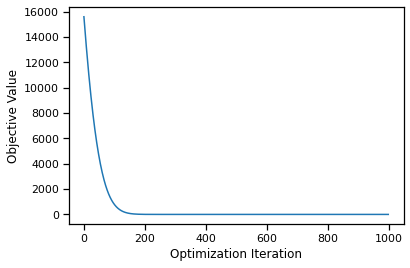

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Optimization Iteration")
plt.ylabel("Objective Value")

In [ ]:
print("Final loss: {:.10f}".format(losses[-1].item()))

Final loss: 0.0000000000


## Problem 2: Neural Network Classification

Next, we will use a neural network to solve a classification problem for which the data is not linearly separable. We will implement the network as a PyTorch `nn.module` and train it using gradient descent, computing gradients using automatic differentation. 

First, we create and visualize a two-dimensional dataset where each point is labeled as positive (1) or negative (0). As seen below, the positive and negative points are not linearly separable.


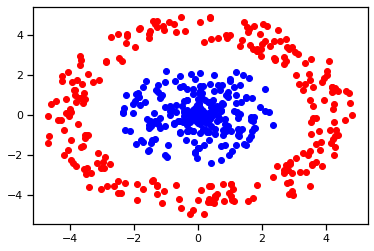

In [ ]:
torch.manual_seed(305)

def make_dataset(num_points):
    radius = 5

    def sample_annulus(inner_radius, outer_radius, num_points):
        r = Uniform(inner_radius, outer_radius).sample((num_points,))
        angle = Uniform(0, 2 * math.pi).sample((num_points,))
        x = r * torch.cos(angle)
        y = r * torch.sin(angle)
        data = torch.vstack([x, y]).T
        return data
    
    # Generate positive examples (labeled 1)
    data_1 = sample_annulus(0, 0.5 * radius, num_points // 2)
    labels_1 = torch.ones(num_points // 2)
        
    # Generate negative examples (labeled 0).
    data_0 = sample_annulus(0.7 * radius, radius, num_points // 2)
    labels_0 = torch.zeros(num_points // 2)
        
    data = torch.vstack([data_0, data_1])
    labels = torch.concat([labels_0, labels_1])

    return data, labels
    
num_data = 500
data, labels = make_dataset(num_data)

# Note: red indicates a label of 1, blue indicates a label of 0
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red') 
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue') 

### Problem 2a: The Maximum Likelihood Objective

We will try to classify this data using a neural network. We posit the following statistical model for the labels $y \in \{0, 1\}$ given features $\mathbf{x} \in \mathbb{R}^2$:
$$ y \mid x \sim \text{Bern}(\sigma(\text{NN}_{\boldsymbol{\theta}}(\mathbf{x})))$$
Here, $\text{NN}_{\boldsymbol{\theta}}: \mathbb{R}^2 \to \mathbb{R}$ denotes a neural network with parameters $\boldsymbol{\theta} \in \mathbb{R}^P$ mapping datapoints $\mathbf{x}$ to $\text{logit}(\mathbb{P}(y = 1 \mid \mathbf{x}))$. Recall the [logit](https://en.wikipedia.org/wiki/Logit) function is given by 
$$\text{logit}(p) = \log \left( \frac{p}{1-p} \right)$$
and its inverse is the [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function): $$\sigma(x) = \frac{1}{1 + \exp (-x)}$$

We estimate the parameters $\boldsymbol{\theta}$ using maximum likelihood. Show that for a dataset $\{(\mathbf{x}_n, y_n)\}_{n=1}^N$ the negative log-likelihood objective, rescaled by the number of datapoints $N$, may be written as:

$$ L(\boldsymbol{\theta}) = \frac{1}{N} \sum_{n = 1}^N -y_n \log \sigma(\text{NN}_{\boldsymbol{\theta}}(\mathbf{x})) - (1 - y_n) \log (1 - 
 \sigma(\text{NN}_{\boldsymbol{\theta}}(\mathbf{x}))) = \frac{1}{N} \sum_{n = 1}^N \ell(y, \text{NN}_{\boldsymbol{\theta}}(\mathbf{x}_n))$$

where $\ell(y, x) = -y \log \sigma(x) - (1 - y) \log(1 - \sigma(x))$.

As set forth above, the predicted probability amounts to a sigmoid layer on top of the NN's output, i.e.
$$
\hat \pi_n = \sigma(\text{NN}_{\boldsymbol{\theta}}(\mathbf{x}_n)).
$$
Hence, for an ordinary set of probability predictions, we have
\begin{align}
  \mathcal{L}(\hat \pi_1,\ldots, \hat \pi_N)
  &=
  \prod_{n=1}^n \hat \pi_n^{y_n}(1-\hat \pi_n)^{1-y_n} \\
  \ell(\hat \pi_1,\ldots, \hat \pi_N)
  &=
  \sum_{n=1}^N y_n\log \hat \pi_n + (1 - y_n)\log(1 - \hat \pi_n) \\
  &=
  \sum_{n=1}^N y_n\log( \sigma(\text{NN}_{\boldsymbol{\theta}}(\mathbf{x}_n))) + (1 - y_n)\log(1 -  \sigma(\text{NN}_{\boldsymbol{\theta}}(\mathbf{x}_n))).
\end{align}
Hence, we get the desired result on 1/N rescaling and negation.

---

*Your answer here.*

---

### Problem 2b: Define the Neural Network

We will use a neural network with two hidden layers, the first of which has three hidden units and the second of which has five hidden units. The equations defining the output $z \in \mathbb{R}$ of our neural network given an input $\mathbf{x} \in \mathbb{R}^2$ are:
\begin{align*}
\mathbf{h}_1 &= \text{ReLU}(\mathbf{W_1} \mathbf{x} + \mathbf{b_1}) \\
\mathbf{h}_2 &= \text{ReLU}(\mathbf{W_2} \mathbf{h}_1 + \mathbf{b_2}) \\
z &= \mathbf{w}_3^\top \mathbf{h}_2 + b_3
\end{align*}
The parameters of the network are $\boldsymbol{\theta} = (\mathbf{W}_1, \mathbf{b}_1, \mathbf{W}_2, \mathbf{b}_2, \mathbf{w}_3, b_3)$ where $\mathbf{W}_1 \in \mathbb{R}^{3 \times 2}, \mathbf{b}_1 \in \mathbb{R}^3, \mathbf{W}_2 \in \mathbb{R}^{5 \times 3}, \mathbf{b}_2 \in \mathbb{R}^5, \mathbf{w}_3 \in \mathbb{R}^5$, and $b_3 \in \mathbb{R}$. 

Implement this network as a PyTorch `nn.module`.

In [ ]:
class SimpleNet(nn.Module):

    def __init__(self, D=2, architecture=[3, 5]):
        super().__init__()
        self.fc1 = nn.Linear(D, architecture[0])
        self.fc2 = nn.Linear(architecture[0], architecture[1])
        self.fcout = nn.Linear(architecture[1], 1)

    def forward(self, x):
        """ Implements the forward pass of the network.

        Args:
            x: torch.tensor of shape (N, 2)
        Returns:
            logits: torch.tensor of shape (N,) containing the logits
        """
        ###
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fcout(x).squeeze(1)
        ##
        return logits

Let's visualize the predictions of an untrained network. As we can see, the network does not succeed at classifying the points without training



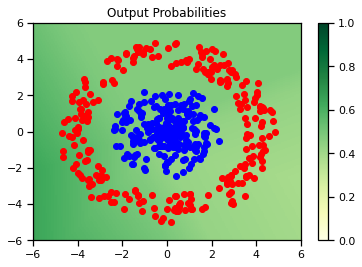

In [ ]:
def visualize_predictions(net):
    num_points = 200
    x1s = np.linspace(-6.0, 6.0, num_points)
    x2s = np.linspace(-6.0, 6.0, num_points)
    X1, X2 = np.meshgrid(x1s, x2s)

    points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
    points = torch.tensor(points, dtype=torch.float)
    with torch.no_grad():
        probs = torch.sigmoid(net(points)).reshape(num_points, num_points)

    plt.pcolormesh(X1, X2, probs, cmap=plt.cm.get_cmap('YlGn'), vmin=0, vmax=1)
    plt.colorbar()
    plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red') 
    plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue') 
    plt.title("Output Probabilities")

torch.manual_seed(305)
model = SimpleNet()
visualize_predictions(model)

### Problem 2c: Train the Network

We will now find the parameters of our network by maximizing the likelihood, or equivalently minimizing the negative log-likelihood. We will use full-batch gradient descent. That is, we will use the gradient $\nabla L(\boldsymbol{\theta})$ itself to update the parameters rather than a stochastic estimate of $\nabla L(\boldsymbol{\theta})$.

Use the SGD optimizer from `torch.optim` with a learning rate of $1$ and no momentum for 1000 iterations. Note that the function $\ell$ from above is implemented in PyTorch as [`nn.BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

In [ ]:
num_steps = 1000
losses = []

###
# YOUR CODE HERE
loss_fn = torch.nn.BCEWithLogitsLoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=1.)
for it in tqdm(range(num_steps)):
    # zero grads
    optimizer.zero_grad()
    # forward pass
    logits = model(data)
    loss = loss_fn(logits, labels)
    # backward pass
    loss.backward()
    # update 
    optimizer.step()
    losses.append(loss.item())
##

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'Objective Value')

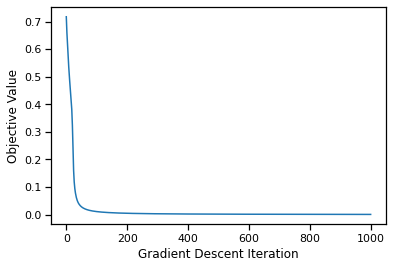

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Gradient Descent Iteration")
plt.ylabel("Objective Value")

Let's visualize the predictions of our trained network. We see that the network has learned to separate the positive and negative examples.

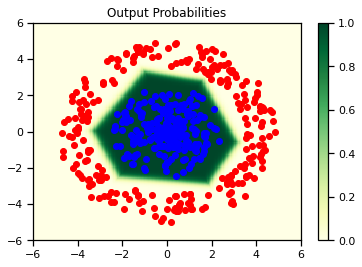

In [ ]:
visualize_predictions(model)

## Problem 3: Amortized Variational Inference

In this problem, we will train a variational autoencoder for the MNIST dataset of handwritten digits. First, let's download this dataset using PyTorch's `datasets` module and visualize some of the digits. We will use a binarized version of the dataset in which each pixel value is either 0 or 1.

In [ ]:
# Download MNIST dataset and create dataloaders. 
def binarize(imgs, integer=False):
    threshold = 127 if integer else 0.5
    imgs = imgs.clone()
    imgs[imgs < threshold] = 0.
    imgs[imgs >= threshold] = 1.
    return imgs

train_dataset = datasets.MNIST(root="data", train=True, download=True,
                         transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='data', train=False, download=True,
                             transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Number of points in dataset: {0}".format(train_dataset.data.shape[0]))
print("Number of batches per epoch: {0}".format(len(train_loader)))

Number of points in dataset: 60000
Number of batches per epoch: 938


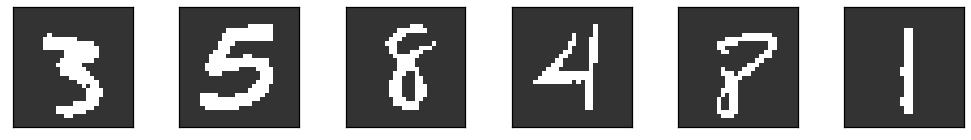

In [ ]:
# Visualize some digits in the dataset.
imgs, _ = next(iter(train_loader))
imgs = binarize(imgs)
fig, ax = plt.subplots(1, 6, figsize=(14, 14))
fig.tight_layout()
for i, ax in enumerate(ax.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(imgs[i].squeeze(), alpha=0.8, cmap='gray')

### Problem 3a: Decoder Network

We represent a $28 \times 28$ image $\mathbf{x}$ as a flattened $784$ dimensional vector of binary values, i.e. $\mathbf{x} \in \{0, 1\}^{784}$. We specify our generative model as:
$$ \mathbf{z} \sim \mathcal{N}(0, I), \quad \mathbf{x} \mid \mathbf{z} \sim \text{Bern}(\sigma(D_{\boldsymbol{\theta}}(\mathbf{z}))$$
Here, $D_{\boldsymbol{\theta}}: \mathbb{R}^2 \to \mathbb{R}^{784}$ is a neural network with parameters $\boldsymbol{\theta}$ and $\mathbf{z} \in \mathbb{R}^{2}$ is a two-dimensional latent variable. We use only two dimensions so that the latent space can be easily visualized later, but using a higher dimensional latent variable would give a more flexible generative model. 

We will parametrize $D_{\boldsymbol{\theta}}$ as a fully connected neural network with two hidden layers and ReLU activations. We use 256 units in the first hidden layer and 512 in the second. Note that as in Problem 2, the network maps to the logits of the Bernoulli distribution and not the probabilities themselves. Implement this decoder network in PyTorch below.

In [ ]:
# Define decoder architecture
class Decoder(nn.Module):
    """ Neural network defining p(x | z) """

    def __init__(self, data_dim, latent_dim, hidden_dims=[256, 512]):
        super().__init__()
        self.data_dim = data_dim

        self.fc1 = nn.Linear(latent_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fcout = nn.Linear(hidden_dims[1], data_dim)
        
    def forward(self, z):
        """ Returns Bernoulli conditional distribution of p(x | z), parametrized
        by logits.
        Args:
            z: (N, latent_dim) torch.tensor
        Returns:
            Bernoulli distribution with a batch of (N, data_dim) logits
        """
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = self.fcout(x).squeeze(1)
        return Bernoulli(logits=x)

### Problem 3b: Encoder Network

We will estimate the parameters of the generative model by maximizing the Evidence Lower Bound (ELBO). As the exact posterior $p(\mathbf{z} \mid \mathbf{x})$ is unknown, we will use an approximate, amortized posterior $q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) = \mathcal{N}(\mathbf{z} \mid \mu_{\boldsymbol{\phi}}(\mathbf{x}), \text{diag}(\sigma^2_{\boldsymbol{\phi}}(\mathbf{x})))$. We let $\left(\mu_{\boldsymbol{\phi}}(\mathbf{x}), \log \sigma^2_{\boldsymbol{\phi}}(\mathbf{x}) \right) = E_{\boldsymbol{\phi}}(\mathbf{x})$ where $E_{\boldsymbol{\phi}}: \mathbb{R}^{784} \to \mathbb{R}^2 \times \mathbb{R}^2$ is a neural network with parameters $\boldsymbol{\phi}$. 

As above, we parametrize $E_{\boldsymbol{\phi}}$ as a neural network with two layers of hidden units and ReLU activations. We use 512 hidden units in the first layer and 256 in the second. Then we let $\mu_{\boldsymbol{\phi}}$ and $\log \sigma^2_{\boldsymbol{\phi}}$ be affine functions of the hidden layer activations. Implement the encoder $E_{\boldsymbol{\phi}}$ in the code below.

In [ ]:
# Define encoder architecture
class Encoder(nn.Module):
    """ Neural network defining q(z | x). """

    def __init__(self, data_dim, latent_dim, hidden_dims=[512, 256]):
        super().__init__()
        self.fc1 = nn.Linear(data_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        # one for each of u and sigma, for each z
        self.fc_mu = nn.Linear(hidden_dims[1], latent_dim)
        self.fc_logsigma = nn.Linear(hidden_dims[1], latent_dim)

    def forward(self, x):
        """ Returns Normal conditional distribution for q(z | x), with mean and
        log-variance output by a neural network.

        Args:
            x: (N, data_dim) torch.tensor
        Returns:
            Normal distribution with a batch of (N, latent_dim) means and standard deviations
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mu(x)
        sigma = torch.exp(self.fc_logsigma(x))
        return Normal(mu, sigma)

### ELBO Derivation [given]

As a function of $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$, we can write the ELBO for a single datapoint $\mathbf{x}$ as:
$$\mathcal{L}(\mathbf{x}, \boldsymbol{\theta}, \boldsymbol{\phi}) = \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})} \left[ \log p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z}) - \log q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) \right]$$

We can obtain a lower bound of the log-likelihood for an entire dataset $\{\mathbf{x}^{(n)} \}_{n=1}^N$, rescaled by the number of datapoints $N$, as:
$$\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}) = \frac{1}{N} \sum_{n=1}^N \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}^{(n)} \mid \mathbf{x}^{(n)})} \left[ \log p_{\boldsymbol{\theta}}(\mathbf{x}^{(n)}, \mathbf{z}^{(n)}) - \log q_{\boldsymbol{\phi}}(\mathbf{z}^{(n)} \mid \mathbf{x}^{(n)}) \right]$$

We can rewrite the per-datapoint ELBO as:
\begin{align*}
\mathcal{L}(\mathbf{x}, \boldsymbol{\theta}, \boldsymbol{\phi}) 
&= \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})} \left[ \log p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mathbf{z}) \right] - \text{KL}\left( q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right) \\
&= \mathbb{E}_{\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})} \left[ \log p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mu_{\boldsymbol{\phi}}(\mathbf{x}) + \boldsymbol{\epsilon} \odot \sigma_{\boldsymbol{\phi}}(\mathbf{x})) \right] - \text{KL}\left( q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right)
\end{align*}

This allows us to obtain an unbiased estimate of the per-datapoint ELBO by first sampling $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, then computing:
$$\hat{\mathcal{L}}(\mathbf{x}, \boldsymbol{\theta}, \boldsymbol{\phi}) = \log p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mu_{\boldsymbol{\phi}}(\mathbf{x}) + \boldsymbol{\epsilon} \odot \sigma_{\boldsymbol{\phi}}(\mathbf{x})) - \text{KL}\left( q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right)$$

This is known as the reparametrization trick, and it will allow us to straightforwardly use automatic differentiation to obtain the gradient of $\hat{\mathcal{L}}$ with respect to $\boldsymbol{\phi}$. 

Given a minibatch $\{\mathbf{x}^{(b)} \}_{b=1}^B$ sampled uniformly from the entire dataset, we can simulate independent normal variates $\boldsymbol{\epsilon}^{(b)}$ to form an unbiased estimator of the ELBO for the entire dataset:
$$\hat{\mathcal{L}}(\boldsymbol{\theta}, \boldsymbol{\phi}) = \frac{1}{B} \sum_{b = 1}^B \log p_{\boldsymbol{\theta}}(\mathbf{x}^{(b)} \mid \mu_{\boldsymbol{\phi}}(\mathbf{x}^{(b)}) + \boldsymbol{\epsilon} \odot \sigma_{\boldsymbol{\phi}}(\mathbf{x}^{(b)})) - \text{KL}\left( q_{\boldsymbol{\phi}}(\mathbf{z}^{(b)} \mid \mathbf{x}^{(b)}) \mid\mid p(\mathbf{z}^{(b)})\right) $$

### Problem 3c: Implement the ELBO

Using our derivations above, implement the estimator of the ELBO $\hat{\mathcal{L}}(\boldsymbol{\theta}, \boldsymbol{\phi})$. We assume sampling of the minibatch `x` is done outside of the function, but you must sample the noise variables $\boldsymbol{\epsilon}$ within the `elbo` function. You should use the `kl_divergence` function imported above to analytically compute the KL divergence between the Gaussian distributions $q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})$ and $p(\mathbf{z})$. Make sure you use `rsample` on a `Distribution` object to use the reparametrization trick and not `sample`.

In [ ]:
def elbo(x, encoder, decoder):
    """ Computes a stochastic estimate of the rescaled evidence lower bound

    Args:
        x: (N, data_dim) torch.tensor
        encoder: an Encoder
        decoder: a Decoder
    Returns:
        elbo: a (,) torch.tensor containing the estimate of the ELBO
    """
    # instantiate
    qz, pz = encoder(x), torch.distributions.Normal(0., 1.)
    # sample via reparam trick
    z = qz.rsample()
    ###
    # Coding note: same as 
    # q_z.mean + q_z.scale * (Normal(0, 1).sample())
    ###
    # YOUR CODE HERE
    elbo_value = (
        decoder(z).log_prob(x).sum(axis=1)
        - kl_divergence(qz, pz).sum(axis=1)
    ).mean()
    ##
    return elbo_value


### Implement the Training Loop [given]

Using our `Encoder` and `Decoder` definitions, as well as the `elbo` function, we have provided training code below. This code uses the [Adam](https://arxiv.org/abs/1412.6980) optimizer, a sophisticated optimization algorithm which uses the history of past gradients to rescale gradients before applying an update.

We train for 20 epochs (an "epoch" refers to a complete pass through the dataset). Our implementation takes 10 minutes to run and achieves a training ELBO of $-135$ and a test ELBO of $-138$.

In [ ]:
encoder = Encoder(data_dim=784, latent_dim=2)
decoder = Decoder(data_dim=784, latent_dim=2)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),
                       lr=3e-4)

num_epochs = 20

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_elbo = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = binarize(x.reshape(x.shape[0], -1))
        optimizer.zero_grad()
        loss = -elbo(x, encoder, decoder)  
        loss.backward()
        train_elbo -= loss.item() * len(x)
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tELBO: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), -loss.item()))
            
    encoder.eval()
    decoder.eval()
    test_elbo = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = binarize(x.reshape(x.shape[0], -1))#.cuda()
            test_elbo += elbo(x, encoder, decoder).item() * len(x)
            
    train_elbo /= len(train_loader.dataset)
    test_elbo /= len(test_loader.dataset)
    
    print('====> Epoch: {} Average ELBO: {:.4f} Test ELBO: {:.4f}'.format(epoch,
                                                                          train_elbo,
                                                                          test_elbo))


Train Epoch: 0 [0/60000 (0%)]	ELBO: -546.592041
Train Epoch: 0 [6400/60000 (11%)]	ELBO: -215.049728
Train Epoch: 0 [12800/60000 (21%)]	ELBO: -193.184799
Train Epoch: 0 [19200/60000 (32%)]	ELBO: -204.893707
Train Epoch: 0 [25600/60000 (43%)]	ELBO: -189.274323
Train Epoch: 0 [32000/60000 (53%)]	ELBO: -186.366592
Train Epoch: 0 [38400/60000 (64%)]	ELBO: -183.730423
Train Epoch: 0 [44800/60000 (75%)]	ELBO: -175.403503
Train Epoch: 0 [51200/60000 (85%)]	ELBO: -164.637650
Train Epoch: 0 [57600/60000 (96%)]	ELBO: -168.281250
====> Epoch: 0 Average ELBO: -193.3335 Test ELBO: -168.8439
Train Epoch: 1 [0/60000 (0%)]	ELBO: -165.393173
Train Epoch: 1 [6400/60000 (11%)]	ELBO: -160.246674
Train Epoch: 1 [12800/60000 (21%)]	ELBO: -169.456909
Train Epoch: 1 [19200/60000 (32%)]	ELBO: -153.684982
Train Epoch: 1 [25600/60000 (43%)]	ELBO: -164.507294
Train Epoch: 1 [32000/60000 (53%)]	ELBO: -156.494659
Train Epoch: 1 [38400/60000 (64%)]	ELBO: -151.618408
Train Epoch: 1 [44800/60000 (75%)]	ELBO: -160.78579

## Problem 3e: Visualize samples from the trained model

In addition to the ELBO, we can sample from the trained model to assess its performance. Use the code below to generate an $8 \times 8$ grid of sampled digits from the model. Note that we follow the common practice of using the mean of $p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mathbf{z})$ rather than resampling from this distribution when visualizing samples. Critique these samples. What aspects of the data distribution does the model seem to have trouble learning?

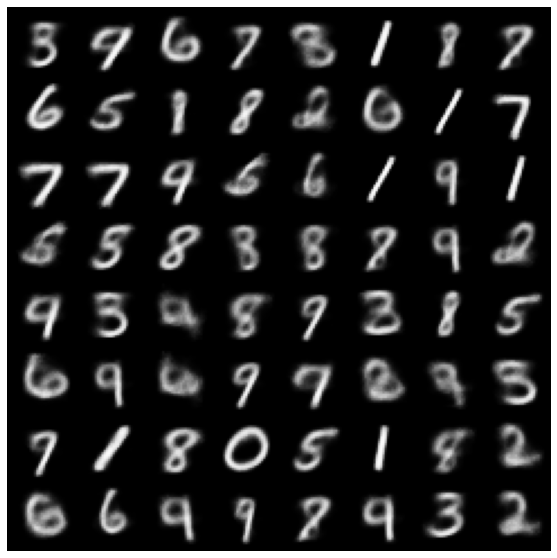

In [ ]:
# Visualize sampled digits from our model
decoder.eval()

num_samples = 64
with torch.no_grad():
    z = torch.randn(num_samples, 2)
    expected_xs = decoder.forward(z).mean 
    expected_xs = expected_xs.reshape(-1, 28, 28).unsqueeze(1)

# Plot the expected_xs as a grid of images
expected_xs_grid = make_grid(expected_xs, nrow=8)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(expected_xs_grid.permute(1, 2, 0), vmin=0., vmax=1.)
plt.show()

---

In general, the numbers look pretty reasonable. Sure, some are a bit blurry and a couple are borderline non-sensical (e.g. 5-6 down/ 3 over) and/or blended on top of one another (e.g. 6 down/ 6 over), but in general things are legible. That said, a couple observations:

* for many of the 1's, the model seems to hedge it's bet on 1 vs. 7 by printing the 1's at an angle. This may be a sign of insufficient learning. 

* The model generally seems to have trouble with 8's, with many parts of the eight blurry. In some cases, it appears to want to connect a 5 into an 8 (6 down/8 over); in other cases, it seems to flatten the eight into a 7, e.g. 8 down/5 over and 4 down/6 over. 

* More generally, the models seems to struggle with curvattures, particularly at the bottom of 6's, 3's, and 2's, as well as the top of 9's and everywhere on 8's. This would seemingly reflect the model (encoder) being uncertain for these curvatures, and in turn putting it's feet in multiple parts of the latent space. 

* Lastly, some 6's and 9's seem to get mildly confused for zeros. This makes sense, given the big loops in all three. 

---

### Problem 3f: Visualize the Latent Embeddings

Given $\mathbf{x}$, we can interpret the mean of the approximate posterior $\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}[\mathbf{z}]$ as a lower dimensional representation of $\mathbf{x}$. In the code below, we find the mean of the approximate posterior for each of the datapoints in the dataset and then visualize these means with a scatter plot. We color each point according to the label of the encoded digit. What do you notice? Are there classes with significant overlap, and are these classes which are visually similar? Is there a class which has clear separation from the others, and if so, why do you think this is? 

Note that we did not provide any information about the class label to either the generative model or the approximate posterior!

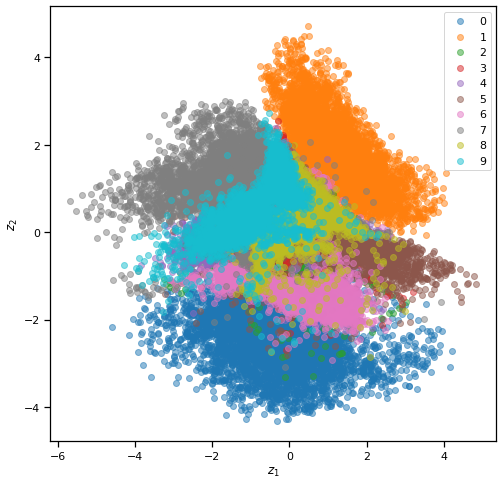

In [ ]:
# Compute the mean of the latents given the data
encoder.eval()
with torch.no_grad():
    means = []
    ys = []
    for x, y in train_loader:        
        x = binarize(x.reshape(x.shape[0], -1))
        mean = encoder.forward(x).mean
        means.append(mean)
        ys.append(y)

means = torch.vstack(means)
ys = torch.hstack(ys)

# Plot the first two dimensions of the latents
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(10):
    means_i = means[ys == i]
    ax.scatter(means_i[:, 0], means_i[:, 1], label=str(i), alpha=.5)

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.legend()

---

Unsurprisingly, the numbers with the most overlap in the latent space seem to bee those most often confused/blurred with each other during reproduction above: for example, 8 with 5,  8 with 9, 8 with 7, 6 with 0, etc. That is, you can generally find structural similarities for shapes with overlapped $z's$, which puts model confusion/blurring of any such pair into better context. 

I was surprised, however, to see minimal overlap between 1 (orange) and grey (7) in this plot, as there was some confusion/blurring between the two in the reproductions above. I would have thought the two would be way more on top of one another.

---

### Problem 3g: Interpolation in the Latent Space

Another desideratum for a latent variable model is smooth interpolation in the latent space. For example, if we linearly interpolate between a latent $\mathbf{z}_{start}$ corresponding to a $7$ and a latent $\mathbf{z}_{end}$ corresponding to a $1$, we should observe the decodings of the interpolations smoothly change from a $7$ to a $1$.

In the code below, we sample $8$ different starting latent variables and $8$ different ending latent variables from the prior, linearly interpolate between them for $10$ points, then plot the decodings. Does our model smoothly change between decoded digits? Are there digit pairs it was more successful interpolating between?

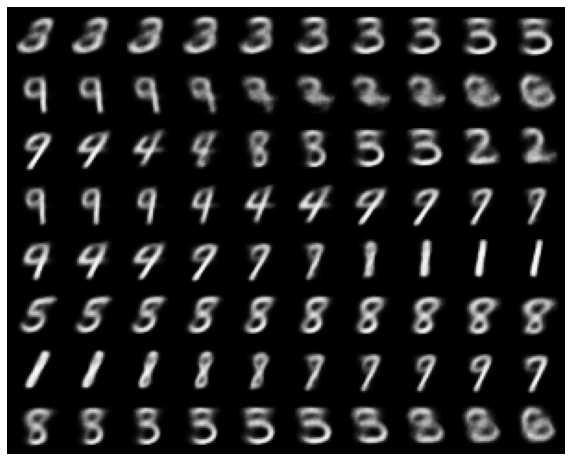

In [ ]:
# Interpolate between 8 randomly chosen start and end points
latent_starts = torch.randn(8, 2)
latent_ends = torch.randn(8, 2)

means = []
for t in torch.linspace(0, 1, 10):
    z = latent_starts + t * (latent_ends - latent_starts)
    with torch.no_grad():
        means.append(decoder.forward(z).mean.reshape(-1, 28, 28).unsqueeze(0))

means_tensor = torch.vstack(means).permute(1, 0, 2, 3).reshape(-1, 28, 28).unsqueeze(1)
sample_grid = make_grid(means_tensor, nrow=10)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

---

In general, interpolation worked and was coherent (at least in my judgment). Rating the rows one-by-one, I'd say:

1.) No transition, pretty much all 3's in this row (maaaaybe you could argue a 5 at the very end). A bit of a surprise, but it looks like the 3<-->5 transition happens in later rows. 

2.) Transition from 9 -> 2 -> 6. This is one of the rougher transitions; the two isn't particularly coherent. 

3.) Transition from 9 -> 4 -> 8 -> 3 -> 5 -> 3 -> 2. A bit of a brisk transition (sometimes three digits in three columns), but in general smooth, insofar as the transitions make sense and can be done by adding/removing one or two lines. 

4.) 9 -> 4 -> 7. These transitions are smooth, and I relate personally since my 4's look like 9's when I write. 

5.) 9 -> 7 -> 1. Perhaps there's an 8 in between the 7 and 1, but overall a pretty smooth evolution. 

6.) 5 -> 8. This is a very smooth transition

7.) 1 -> 8 -> 7 -> 9 -> 7. Again, pretty smooth. 

8.) 8 -> 3 -> 5 -> 3 -> 8 -> 6. Generally a smooth evolution.


---

## Problem 4: Reflections

### Problem 4a

Discuss one reason why we use amortized variational inference rather than optimizing per-datapoint latent variables $\mu^{(n)}, (\boldsymbol{\sigma}^2)^{(n)}$ (so $p(\mathbf{z^{(n)}} \mid \mathbf{x}^{(n)})= \mathcal{N}(\mathbf{z}^{(n)} \mid \mu^{(n)}, \text{diag}((\boldsymbol{\sigma}^2)^{(n)})$).

---

In using amortized VI, we traded exactitude/precision for computational viability. From a computational perspective, it would have killed us to approximate posterior params for each data point; hence, we told a single network to take the original features and approximate that approximation.

In short, to make things computationally viable, we opted for a faster, albeit sub-optimal E-step.

---

### Problem 4b

Describe one way you could improve the variational autoencoder, either by changing the encoder or decoder network structure or by changing the  model itself, and why you think your proposed change would help.


---

First of all, some tuning/experimentation with i.) deeper networks (i.e. more layers in encoder/decoder) may help with the confusion/blurring described above, as well as ii.) finding the appropriate regularization (dropout/L1/L2 probably) for this expanded structure. 

Additionally, it may be worth using some number of convolutional and/or pooling filters to downsample/extract relevant features from the image (in order to more easily capture spatial relationships, translations, visual things of that sort), and then reconstruct via upsampling/transposed convolutions. This is a popular strategy in VAEs, and may improve the performance here marginally.

---

### Problem 4c

Suppose rather than using a Gaussian prior on $\mathbf{z}$, we used $\mathbf{z} \overset{ind}{\sim} \text{Bern}(0.5)$. We can modify $E_{\boldsymbol{\phi}}$ to output logits for a multivariate Bernoulli distribution: $p(\mathbf{z} \mid \mathbf{x}; \boldsymbol{\phi}) = \text{Bern}(\mathbf{z}; \sigma(E_{\boldsymbol{\phi}}(\mathbf{x})))$. Where would our optimization procedure break down in this case?

---

Sadly, we're taking gradients here, for which we need a continuous distribution. The Bernoulli is not one, which would break autodifferentiation.

---

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and remove the Open in Colab button.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourname>_hw6.ipynb
```


**Installing nbconvert:**

If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf files to Gradescope. 